# Descrição do projeto

A empresa *Sweet Lift Taxi* coletou dados históricos sobre pedidos de táxi nos aeroportos. Para atrair mais motoristas na hora do rush, precisamos prever o número de pedidos de táxi para a próxima hora.

## Objetivos:
- Criar um modelo de aprendizado de máquina para prever o número de pedidos de táxi na próxima hora.
- Medir a qualidade do modelo com a métrica RECM no conjunto de teste; obter uma pontuação inferior a 48.

## Descrição de dados

Os dados são armazenados no arquivo `taxi.csv`.
O número de pedidos está na coluna `num_orders`.

## Preparação de dados

In [ ]:
# Bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model    import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor

from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import ForecastingRandomizedSearchCV
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import mean_squared_error as mse

%matplotlib inline

In [ ]:
# load data
try:
    df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

df.sort_index(inplace=True)

In [ ]:
# Checar se data e hora estão em ordem cronológica
df.index.is_monotonic_increasing

True

In [ ]:
print(f'Number of missing values: {df.isna().sum()}')

Number of missing values: num_orders    0
dtype: int64


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [ ]:
df

num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32
...                         ...
2018-08-31 23:10:00          32
2018-08-31 23:20:00          24
2018-08-31 23:30:00          27
2018-08-31 23:40:00          39
2018-08-31 23:50:00          53

[26496 rows x 1 columns]

O conjunto de dados contém informações por 5 meses sobre o número de táxis encomendados entre 1º de março de 2018 às 00:00:00 e 31 de agosto de 2018 às 23:50:00, cada registro é feito a cada 10 minutos. Com um total de 26496 observações.

## Análise de dados

Primeiro vamos alterar o intervalo de nossa série temporal, realizando uma reamostragem horária dos dados.

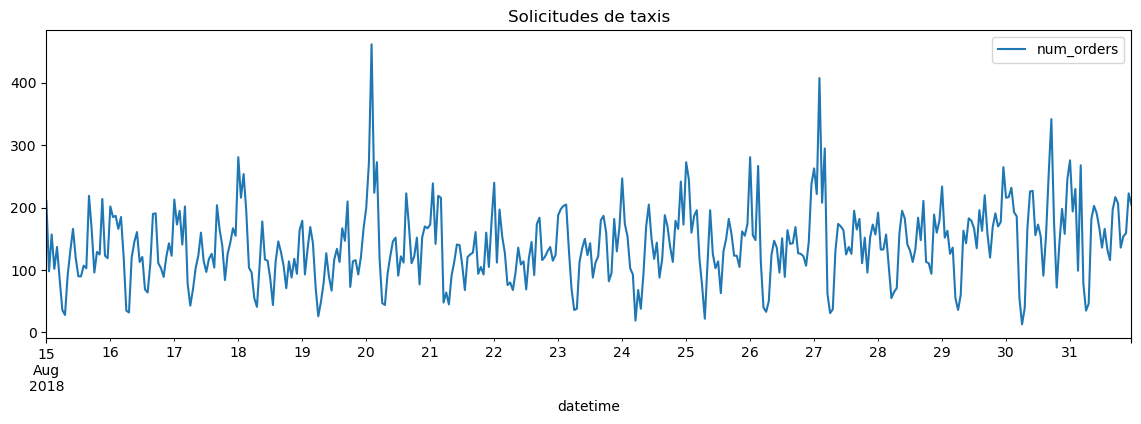

In [ ]:
# Reamostrar por hora
df = df.resample('1H').sum()
df['2018-08-15':'2018-08-31'].plot(figsize=(14,4))
plt.title('Solicitudes de taxis')
plt.show()

Observamos em nossa amostra que há um certo comportamento em nossos dados. Vamos analisar melhor obtendo a tendência, sazonalidade e resíduos de:

  - 2 últimos meses
  - 6 últimos dias

### Pedidos de táxi nos últimos 2 meses

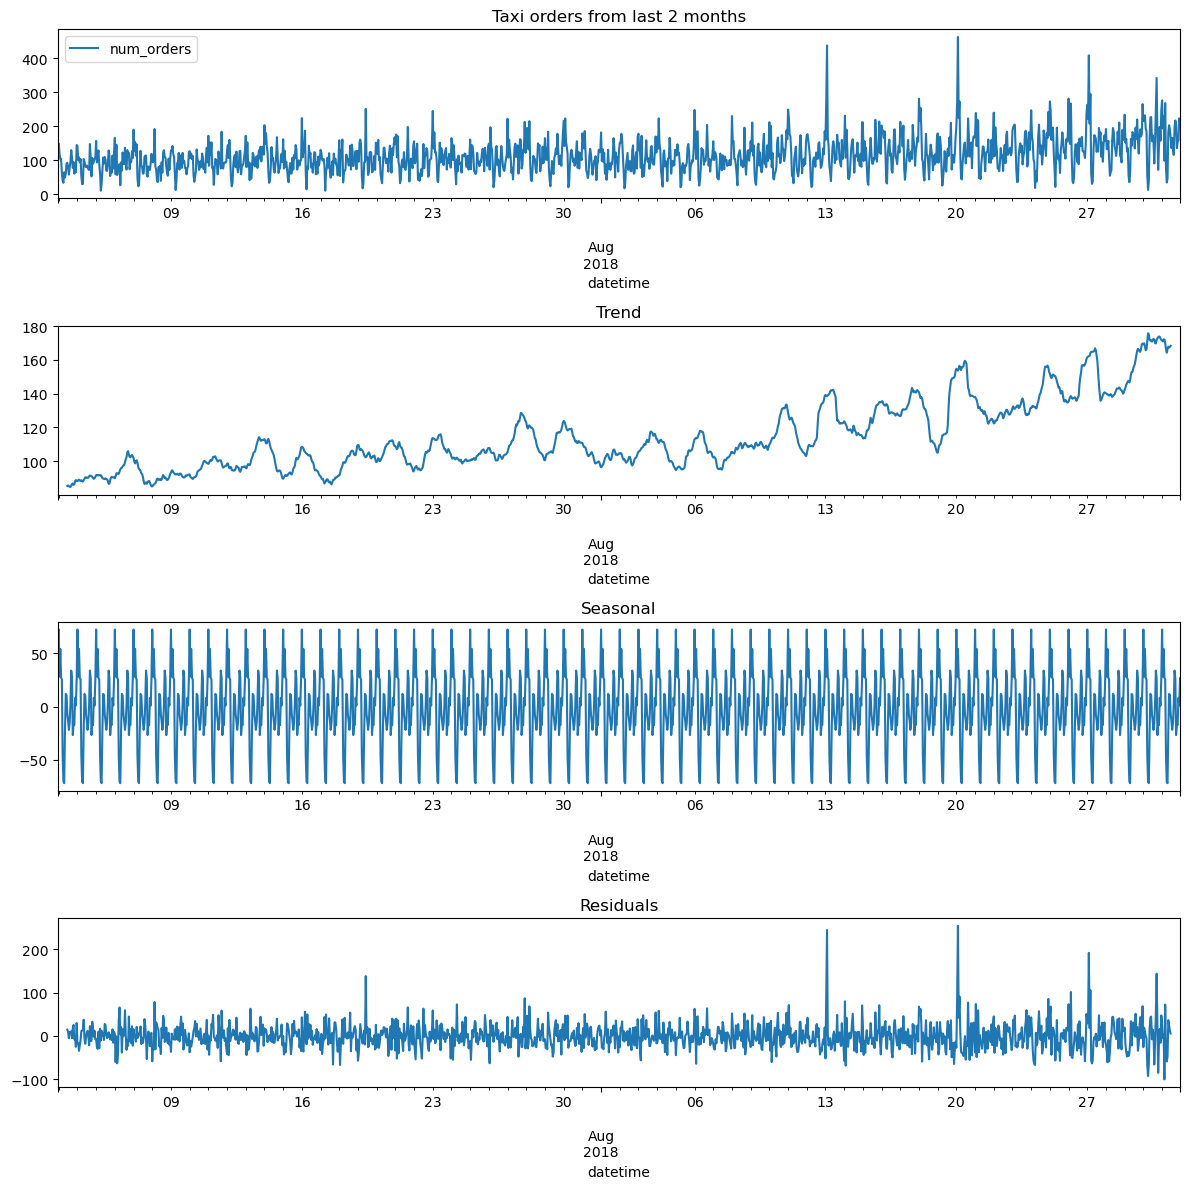

In [ ]:
# últimos 2 meses

days=60
start = df.index.max() - pd.Timedelta(days=days)
end = df.index.max()

decomposed = seasonal_decompose(df[start:end])

plt.figure(figsize=(12, 12))

# Dados Originais
plt.subplot(411)
df[start:end].plot(ax=plt.gca())
plt.title('Taxi orders from last 2 months')

# Tendências
plt.subplot(412)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

# Sazonalidade
plt.subplot(413)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonal')

# Residuais
plt.subplot(414)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()
plt.show()

Observamos os números dos pedidos de táxi dos últimos 2 meses, vemos que nossa série temporal não é estacionária; há uma clara tendência crescente e padrões diários repetitivos de sazonalidade.

### Pedidos de táxi nos últimos 6 dias

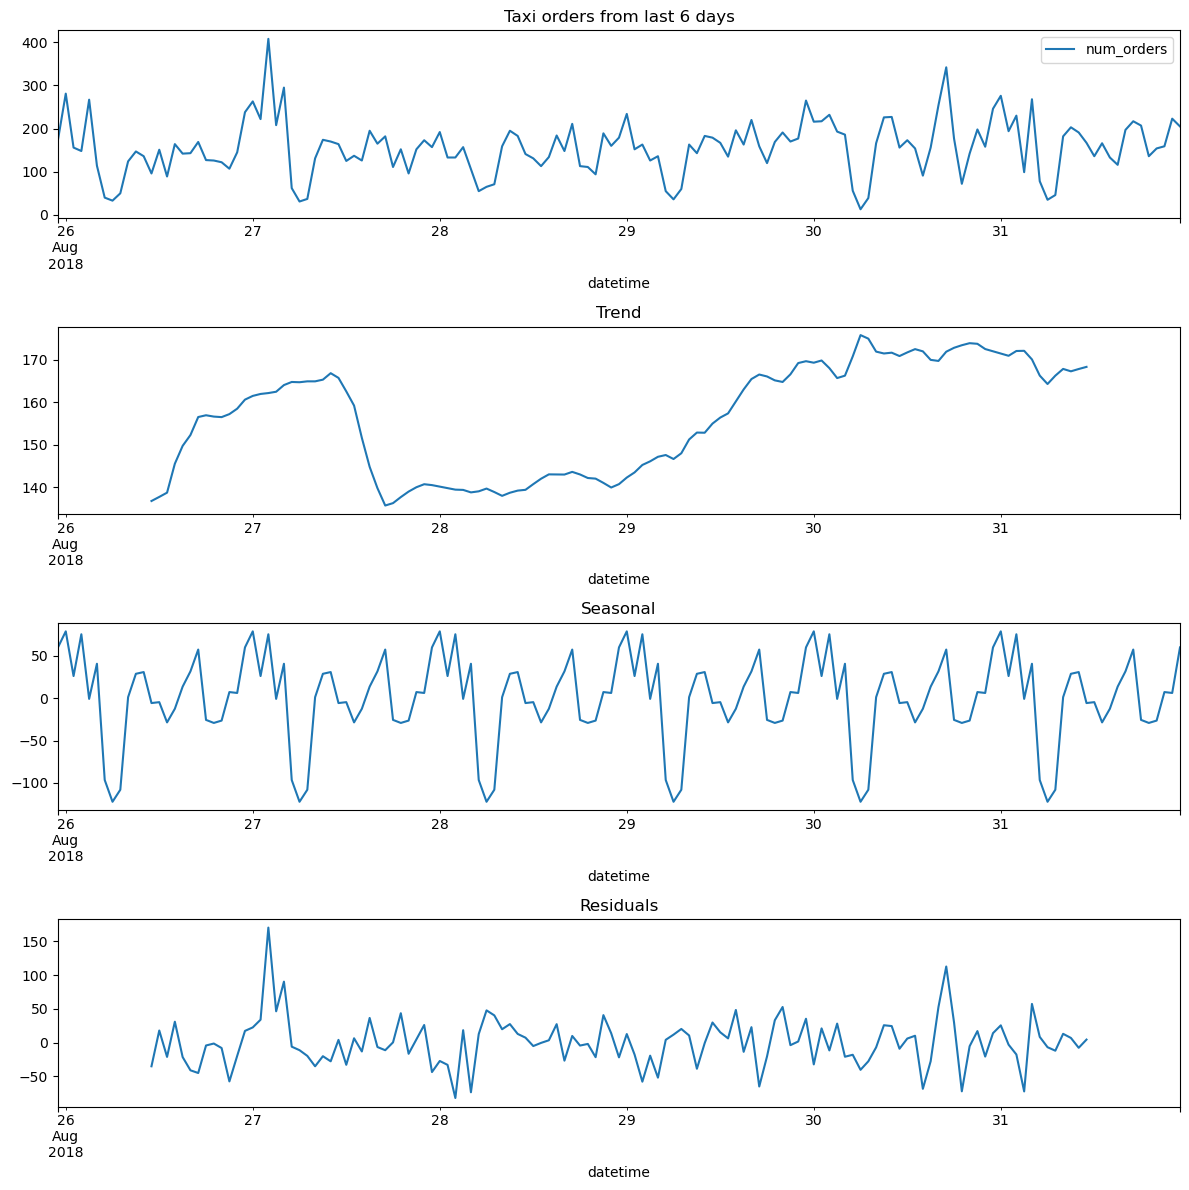

In [ ]:
# últimos 6 dias

days=6
start = df.index.max() - pd.Timedelta(days=days)
end = df.index.max()

decomposed = seasonal_decompose(df[start:end])

plt.figure(figsize=(12, 12))

# Dados Originais
plt.subplot(411)
df[start:end].plot(ax=plt.gca())
plt.title('Taxi orders from last 6 days')

# Tendências
plt.subplot(412)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

# Sazonalidade
plt.subplot(413)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonal')

# Residuais
plt.subplot(414)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()
plt.show()

Analisamos as horas dos últimos 6 dias, e notamos que há uma tendência geral de aumento, os pedidos de táxi estão aumentando um pouco ao longo do tempo. Além disso, os dados são estacionários, pois observa-se um padrão repetitivo, todos os dias nas primeiras horas da manhã há um pico que cai, durante o dia há picos altos e principalmente tarde da noite pode haver muitas corridas de táxi. O gráfico de resíduos nos fornece informações sobre flutuações não explicadas pela tendência e sazonalidade.

## Verificar a estacionaridade

De acordo com os gráficos anteriores, observamos que nossa série temporal não é estacionária, então vamos convertê-la realizando uma diferenciação.

In [ ]:
# Aplicar a primeira diferenciação para remover a estacionariedade do processo
df.num_orders = df.num_orders - df.num_orders.shift()
# df = pd.Series(df, index=df.index)
df.dropna(inplace=True)

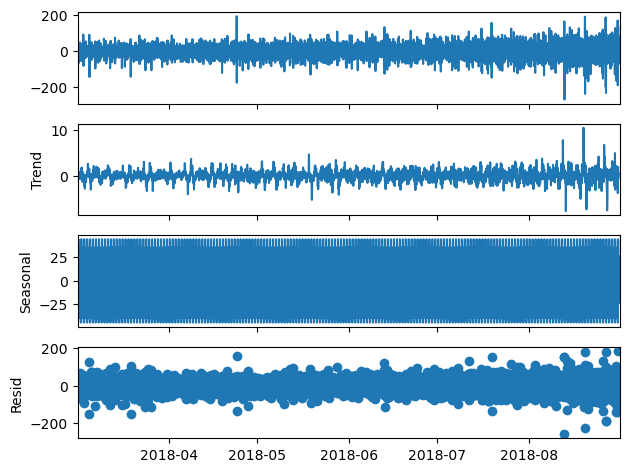

In [ ]:
result = seasonal_decompose(df)
result.plot();

Feito isso, ajudamos nossa série a ficar estacionária, e observamos que não há mais tendência em nossos dados. Agora estamos prontos para começar nossos treinos.

# Modelo de treinamento

Vamos treinar vários modelos para prever o número de pedidos de táxi na próxima hora e faremos a avaliação com a métrica RECM.


Criaremos uma função para criar recursos com base em nossa série temporal.

In [ ]:
# Funcao para criar caracteristicas

def make_features(df, max_lag, rolling_mean_size):

    """
    parameters:
    "df" is the dataset with our target
    "max_lag" is the number of the lags to use
    "rolling_mean_size" is size of the window for media movil

    return features
    """

    df_with_features = df.copy()
    df_with_features['month'] = df.index.month
    df_with_features['day'] = df.index.day
    df_with_features['dayofweek'] = df.index.dayofweek
    df_with_features['hour'] = df.index.hour

    # valores lags
    for lag in range(1, max_lag + 1):
        df_with_features['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    # Media movel
    df_with_features['rolling_mean'] = (df['num_orders'].shift().rolling(rolling_mean_size).mean())

    return df_with_features

In [ ]:
# Criar dataframe com outras características
lags = 15
rolling_mean = 6
df_with_features = make_features(df, lags, rolling_mean)

In [ ]:
# Segmentacao dos dados de treino e teste
train, test = train_test_split(df_with_features, test_size=0.1, shuffle=False)
train.dropna(inplace=True)

# Características e alvos
X_train = train.drop('num_orders', axis=1)
X_test =  test.drop('num_orders', axis=1)

y_train = train['num_orders']
y_test  = test['num_orders']

# Checa dimensoes
print(f'Train: {train.index.min()} --- {train.index.max()}  (n={len(train)})')
print(f'Test : {test.index.min()} --- {test.index.max()}  (n={len(test)})')

Train: 2018-03-01 16:00:00 --- 2018-08-13 13:00:00  (n=3958)
Test : 2018-08-13 14:00:00 --- 2018-08-31 23:00:00  (n=442)


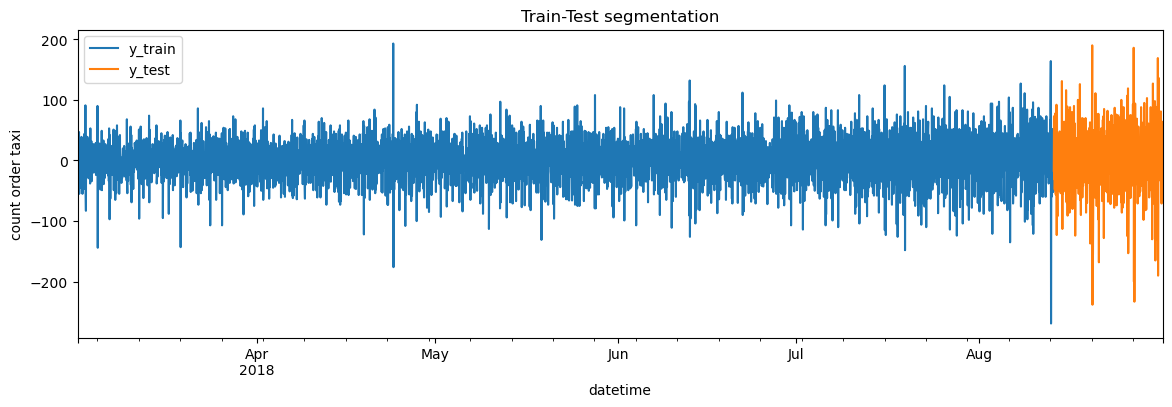

In [ ]:
# Plot da segmentacao dos dados de treino e teste
fig, ax = plt.subplots(figsize=(14, 4))
y_train.plot(ax=ax, label='y_train')
y_test.plot(ax=ax, label='y_test')
plt.ylabel('count order taxi')
plt.title('Train-Test segmentation')
ax.legend()
plt.show()

In [ ]:
# Funcao grid_search
def grid_search_cv(estimator, params, X, y):

    '''
    parameters:
    "estimator": algorithm to train
    "params": hyperparameters
    "x": features
    "y": target

    return: the best parameters

    '''
    tscv = TimeSeriesSplit(n_splits=5)

    grid_search= GridSearchCV(estimator=estimator,
                              param_grid=params,
                              scoring='neg_root_mean_squared_error',
                              cv=tscv)

    grid_search.fit(X, y)

    max_score = grid_search.cv_results_['mean_test_score'].max()

    index_max_score = np.where(grid_search.cv_results_['mean_test_score'] == max_score)[0][0]
    best_params = grid_search.cv_results_['params'][index_max_score]

    print(f'Best hiperparameters: {best_params}')
    return best_params

In [ ]:
# Salva as métricas dos modelos
summary_models = pd.DataFrame(columns=['model', 'rmse'])

## Modelo 1: Linear Regression

In [ ]:
# Modelo com Regressao Linear

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

y_pred_lr = model_lr.predict(X_test)
pred_lr = pd.Series(y_pred_lr, index=y_test.index)

rmse = mean_squared_error(y_test, pred_lr, squared=False)
rmse = round(rmse, 2)

summary_models.loc[1] = {'model': 'LinearRegression', 'rmse': rmse}

print('RECM', rmse)

RECM 51.36


In [ ]:
# Especifica numero de dias para o grafico que segue

days=2

start_train = train.index.max() - pd.Timedelta(days=days)
end_train = train.index.max()
start_test = test.index.min()
end_test = test.index.min() + pd.Timedelta(days=days)

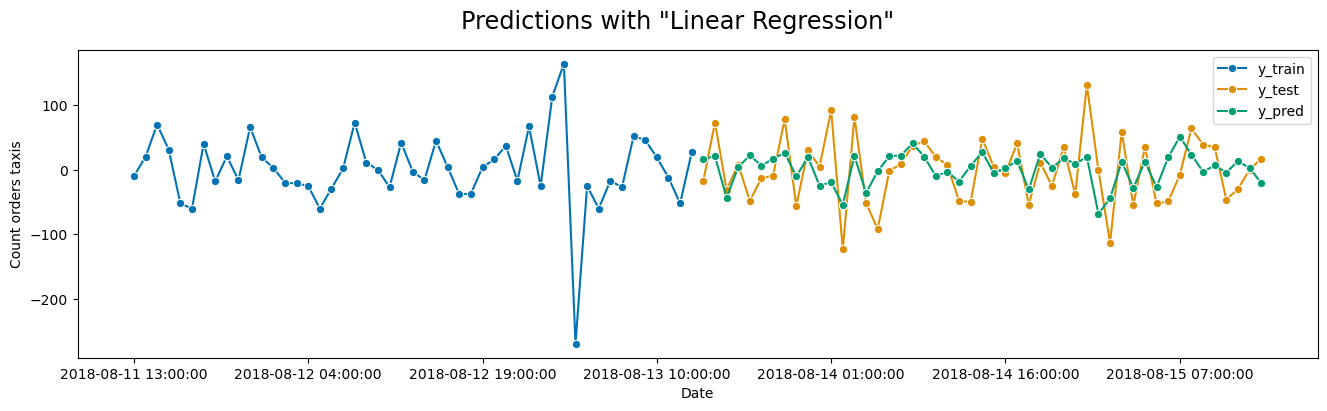

In [ ]:
# Plot

plot_series(y_train[start_train:end_train], y_test[start_test:end_test], pred_lr[start_test:end_test],
            labels=["y_train", "y_test", "y_pred"],
            x_label='Date',
            y_label='Count orders taxis',
            title='Predictions with "Linear Regression"');

Este modelo foi treinado com *Linear Regression*, e obtendo um RECM de 51, precisando melhorar.

## Modelo 2: Decision Tree Regressor

In [ ]:
# Ajustando hiperparâmetros:

params_dt = {'max_depth': range(4,20,2),
             'min_samples_split': range(4,20,2),
             'min_samples_leaf': range(4,20,2)
             }

params = grid_search_cv(DecisionTreeRegressor(), params_dt, X_train, y_train)

Best hiperparameters: {'max_depth': 8, 'min_samples_leaf': 16, 'min_samples_split': 6}


In [ ]:
# Treinando DecisionTreeRegressor

model_dt = DecisionTreeRegressor(max_depth = params['max_depth'],
                                 min_samples_leaf= params['min_samples_leaf'],
                                 min_samples_split = params['min_samples_split']
                                 )

model_dt.fit(X_train, y_train)

pred_dt = model_dt.predict(X_test)
pred_dt = pd.Series(pred_dt, index=y_test.index)
rmse = round(mean_squared_error(y_test, pred_dt, squared=False), 2)

summary_models.loc[2] = {'model': 'DecisionTreeRegressor', 'rmse': rmse}

print(f'RMSE {rmse}')
print(model_dt.get_params())

RMSE 49.25
{'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 8, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 16, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}


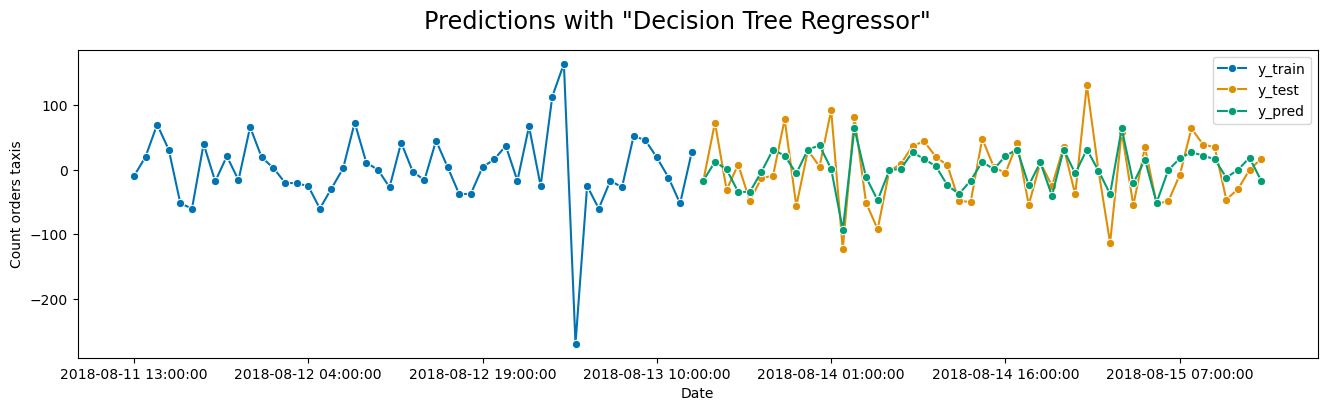

In [ ]:
# Plot
plot_series(y_train[start_train:end_train], y_test[start_test:end_test], pred_dt[start_test:end_test],
            labels=["y_train", "y_test", "y_pred"], x_label='Date', y_label='Count orders taxis',
            title='Predictions with "Decision Tree Regressor"');

Ajustamos nossos hiperparâmetros de nossa árvore de decisão e obtivemos uma pontuação de 49. Certamente melhorou, mas ainda precisamos ajustar. Agora vamos tentar *Random Forest*.

## Modelo 3: Random Forest Regressor

In [ ]:
# Ajustando hiperparâmetros:

params_rf = {'max_depth': range(4,20,2),
             'n_estimators': range(4,40,2),
             }

params = grid_search_cv(RandomForestRegressor(), params_rf, X_train, y_train)

Best hiperparameters: {'max_depth': 18, 'n_estimators': 36}


In [ ]:
# Treinando RandomForestRegressor

model_rf = RandomForestRegressor(max_depth = params['max_depth'],
                                 n_estimators= params['n_estimators'],
                                 )

model_rf.fit(X_train, y_train)

pred_rf = model_rf.predict(X_test)
pred_rf = pd.Series(pred_rf, index=y_test.index)
rmse = round(mean_squared_error(y_test, pred_rf, squared=False), 2)

summary_models.loc[3] = {'model': 'RandomForestRegressor', 'rmse': rmse}

print(f'RMSE {rmse}')
print(model_rf.get_params())

RMSE 44.58
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 18, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 36, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


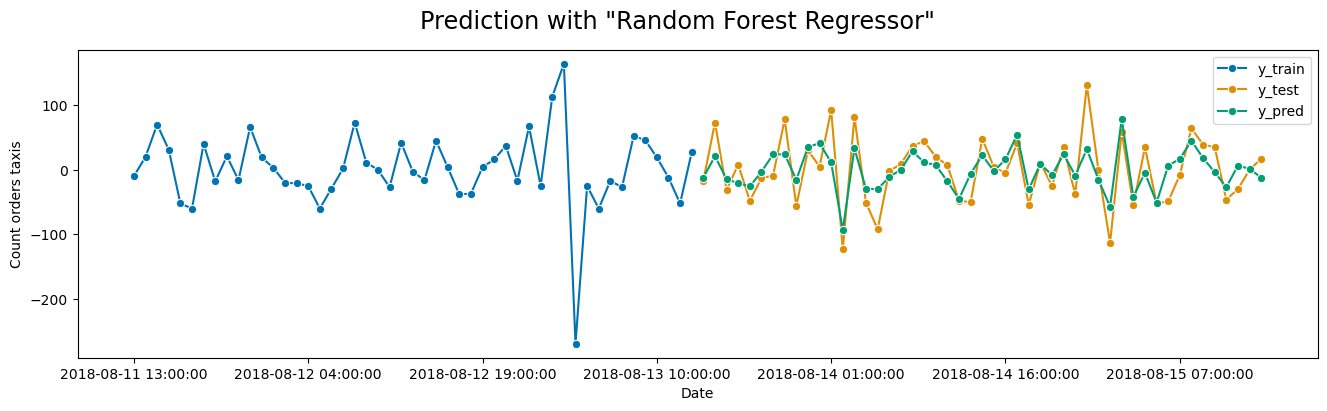

In [ ]:
# Plot
plot_series(y_train[start_train:end_train], y_test[start_test:end_test], pred_rf[start_test:end_test],
            labels=["y_train", "y_test", "y_pred"], x_label='Date', y_label='Count orders taxis',
            title='Prediction with "Random Forest Regressor"');

Obtivemos um bom modelo com uma pontuação de 44 após realizar o ajuste de hiperparâmetros, então *Random Forest* é o melhor modelo até agora.

## Modelo 4: LGBMRegressor

In [ ]:
# Ajustando hiperparâmetros:

param_lgbm = {'num_leaves': [10, 20, 30],
              'learning_rate': [0.1, 0.5],
              'max_depth': [-1,5],
              'n_estimators': [10, 50, 100]
              }

params = grid_search_cv(LGBMRegressor(), param_lgbm, X_train, y_train)

Best hiperparameters: {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 100, 'num_leaves': 20}


In [ ]:
# Treinando LGBMRegressor

model_lgbm = LGBMRegressor(learning_rate= params['learning_rate'],
                             max_depth= params['max_depth'],
                             n_estimators= params['n_estimators'],
                             num_leaves = params['num_leaves'])

model_lgbm.fit(X_train, y_train)

pred_lgbm = model_lgbm.predict(X_test)
pred_lgbm = pd.Series(pred_lgbm, index=y_test.index)
rmse = round(mean_squared_error(y_test, pred_lgbm, squared=False), 2)

summary_models.loc[4] = {'model': 'LGBMRegressor', 'rmse': rmse}

print(f'RMSE {rmse}')
print(model_lgbm.get_params())

RMSE 42.48
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 20, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


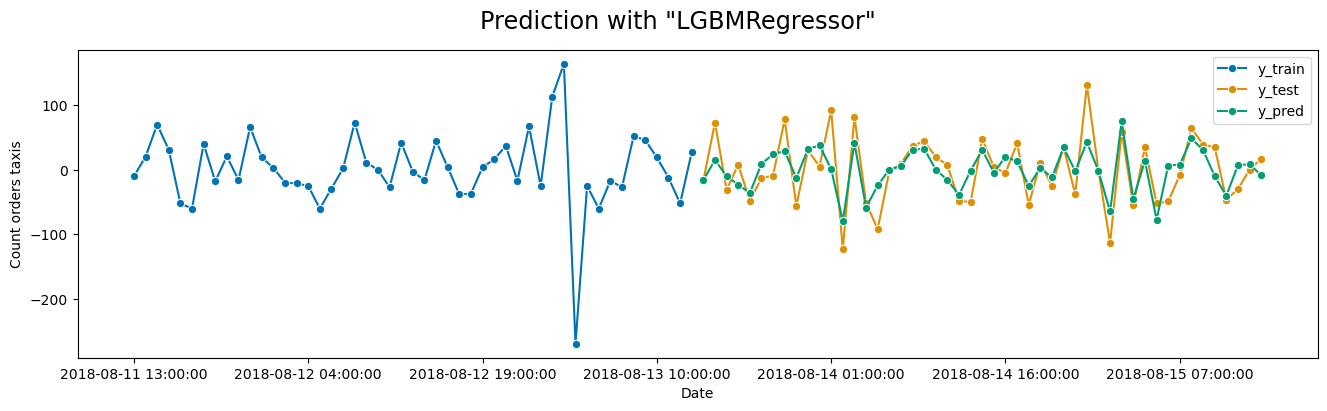

In [ ]:
# Plot
plot_series(y_train[start_train:end_train], y_test[start_test:end_test], pred_lgbm[start_test:end_test],
            labels=["y_train", "y_test", "y_pred"], x_label='Date', y_label='Count orders taxis',
            title='Prediction with "LGBMRegressor"');

Obtém-se um bom resultado, usando o modelo LGBMRegressor com ajuste de hiperparâmetros obteve uma boa pontuação de 42, superando o *Random Forest*.

## Modelo 5: Recursive Tabular Regression "RandomForestRegressor" Forecaster

Podemos usar a redução para transformar uma tarefa de previsão em um problema de regressão tabular. Isso significa que podemos resolver uma tarefa de previsão usando os estimadores da API scikit-learn com *Random Forest*.

Usa-se `make_reduction` da biblioteca `sktime`, para gerar um previsor baseado em redução, usando modelos de regressão do scikit-learn: LinearRegression, RandomForestRegressor. Uso da API `sktime` se assemelha à API `scikit-learn` adaptada como série temporal.

- A função `make_reduction` transforma a série temporal em dados tabulares compatíveis com nosso estimador (LinearRegression, RandomForest, etc). O parâmetro, `window_length`, controla o número de atrasos em nossa transformação de janela deslizante.

- Usa-se `ForecastingHorizon()` dando a ele o índice da série temporal de teste para gerar o horizonte de previsão; isso conterá os timestamps para os quais deseja-se gerar uma previsão obtida dos dados de teste: y_test. Isso significa que você deseja gerar uma previsão por hora para cada um desses 18 dias.

In [ ]:
# Forecasting horizon, same as test data
fh = ForecastingHorizon(y_test.index, is_relative=False) # Predict from the last 442 hours (18 days)

regressor = LGBMRegressor(max_depth= 3,
                          n_estimators= 30,
                          num_leaves = 5,
                          learning_rate=0.01
                          )

# Linear regression forecaster
model_frf = make_reduction(estimator= regressor, strategy='recursive', window_length= 10)

# Fit and predict
model_frf.fit(y_train)
pred_lgbmf = model_frf.predict(fh)

# Evaluate with rmse
rmse = round(mse(y_test, pred_lgbmf, square_root=True), 2) # square_root=True for rmse
summary_models.loc[5] = {'model': 'LGBMRegressor Forecaster', 'rmse': rmse}

print('\nRECM:', rmse)


RECM: 58.87


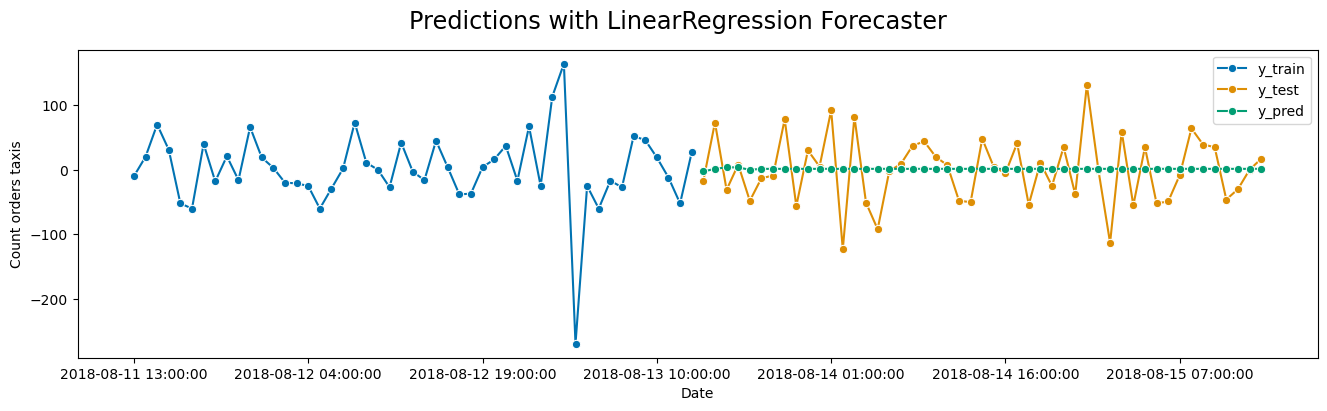

In [ ]:
# Plot
plot_series(y_train[start_train:end_train], y_test[start_test:end_test], pred_lgbmf[start_test:end_test],
            labels=["y_train", "y_test", "y_pred"],
            x_label='Date',
            y_label='Count orders taxis',
            title='Predictions with LinearRegression Forecaster');

Treina-se o modelo *Linear Regression Forecaster*, obtendo uma pontuação não tão boa. O gráfico confirma esse ajuste.

## Análises dos modelos

In [ ]:
summary_models

model   rmse
1          LinearRegression  51.36
2     DecisionTreeRegressor  49.25
3     RandomForestRegressor  44.58
4             LGBMRegressor  42.48
5  LGBMRegressor Forecaster  58.87

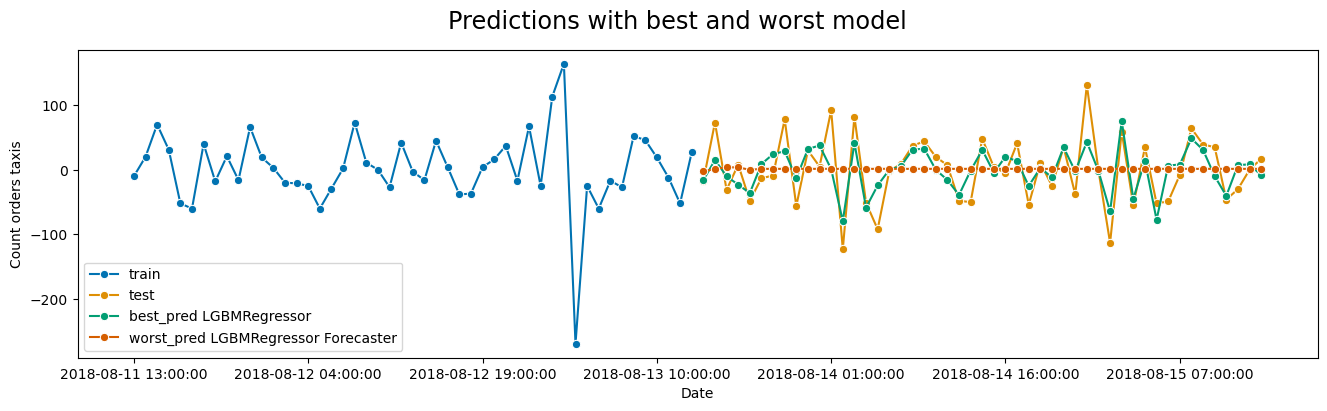

In [ ]:
# Plot
plot_series(y_train[start_train:end_train], y_test[start_test:end_test], pred_lgbm[start_test:end_test], pred_lgbmf[start_test:end_test],
            labels=["train", "test", "best_pred LGBMRegressor", "worst_pred LGBMRegressor Forecaster"],
            x_label='Date',
            y_label='Count orders taxis',
            title='Predictions with best and worst model');

Treina-se 5 modelos preditivos para a série temporal. A tabela summary_models  mostra através do RMSE como cada modelo foi ajustado. O objetivo era obter uma pontuação máxima de 48, pelo que almejava com o objetivo. E resultou que o modelo melhor ajustado é o LGBM Regressor.

## Conclusão

Realizamos análises de estacionariedade nas séries temporais abordadas e aplicou-se diferenciação para converter estas séries temporais em estacionárias.

Treinou-se os modelos abordados para prever pedidos de táxi na próxima hora. Conseguiu-se obter um resumo de cada modelo com suas métricas e visualmente se nota como estavam indo com as previsões.

Aplicou-se ajustes dos hiperparâmetros e alcançou o melhor modelo com o seguinte detalhamento:
- algoritmo: `LGBMRegressor`
- hiperparâmetros:
    `'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split',
    'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001,
    'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 20, 'objective': None,
    'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0,
    'subsample_for_bin': 200000, 'subsample_freq': 0`
- Avaliação do modelo, com métrica RMSE: `42`